> 🎯 In this notebook, we're going to train a Recommendation System based on Autoencoders.

# 📌 Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
%matplotlib inline

2025-07-10 12:59:58.275185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752148798.295359   34910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752148798.301325   34910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752148798.316833   34910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752148798.316860   34910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752148798.316863   34910 computation_placer.cc:177] computation placer alr

# 🎲 Data

The dataset we're going to use is a preprocessed version of this [Kaggle Dataset][dataset]. 
In case you want to take a look, the preprocessing code can be found in this [Github Repo][repo].


Basically, our data contains information about interactions between users and games. Each row contains:
- `user_id`: id of the user
- `content_id`: id of the game
- `game`: name of the game
- `view`: whether a user bought the corresponding game

[dataset]: https://www.kaggle.com/tamber/steam-video-games
[repo]: https://github.com/marlesson/recsys_autoencoders/blob/master/data_preparation.py

In [2]:
df = pd.read_csv("interactions_full_df.csv")
df = df[['user_id', 'content_id', 'game', 'view']]
df.head(20)

,user_id,content_id,game,view
0,0,226,Alien Swarm,1
1,0,846,Cities Skylines,1
2,0,972,Counter-Strike,1
3,0,978,Counter-Strike Source,1
4,0,1125,Day of Defeat,1
5,0,1173,Deathmatch Classic,1
6,0,1242,Deus Ex Human Revolution,1
7,0,1328,Dota 2,1
8,0,2054,Half-Life,1
9,0,2055,Half-Life 2,1


We'll also load a dataframe that maps the `content_id` (id of the game) with the corresponding game.

In [3]:
df_game = pd.read_csv("articles_df.csv")
df_game.head(10)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6
5,5,100% Orange Juice,10,88.3
6,6,1000 Amps,2,2.1
7,7,12 Labours of Hercules,10,44.7
8,8,12 Labours of Hercules II The Cretan Bull,12,46.3
9,9,12 Labours of Hercules III Girl Power,6,25.6


To finish processing our data, we're going to create an interaction matrix between users and games. In this case:
- each row represents a user;
- each column represents a game; and
- each cell indicates if a user bought that game (1) or not (0).

In [4]:
users_items_matrix_df = df.pivot(
    index='user_id', 
    columns='content_id', 
    values='view'
).fillna(0)

users_items_matrix_df.head(10)

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
users_items_matrix_df.shape

(3757, 5113)

As we can see, there are a total of 3757 users and 5113 games. Also, it is a very sparse matrix since most values are 0. In fact, only 0.5% of values are not zero.

# Model

### What are Autoencoders

In this notebook, we're going to use Autoencoders tobuilding a recommendation system. In summary:

> 💡 **Autoencoders are a specific type of neural network capable of discovering structures within data to create a compressed input representation**.

They are considered an unsupervised (sometimes, self-supervised) learning technique to leverage neural networks for representation learning. In the last years, Autoencoders have been successfully applied to many distinct tasks like dimensionality reduction, information retrieval tasks, anomaly detection, and image segmentation.

The architecture of Autoencoders (see figure below) is usually composed of two parts:

![Autoencoders](https://www.deeplearningbook.com.br/wp-content/uploads/2019/11/autoencoders-1024x252.png)

- **Encoder**: responsible for learning a useful representation of the input, also called as **embedding**, **latent representation**, or even **code**. It can be formulated as an encoder function $h = f(x)$, where $x$ is the input and $h$ corresponds to the codification of the input in the latent space ($h: \mathbb{R}^D \rightarrow \mathbb{R}^K$, where $D$ and $K$ represent the dimensionality of the input and latent space, respectively).

- **Decoder**: maps the learned latent representation $h$ back to the original input space ($\mathbb{R}^K \rightarrow \mathbb{R}^D$). It can be described as a reconstruction function $r = g(h)$, where $r$ is the reconstructed input.

Since the exact copy of the input, $g(f(x)) = x$, is not especially useful, Autoencoders are intentionally designed to be unable to learn a perfect copy. Usually, Autoencoders are regularized in ways that allow them to learn an approximation of the identity function. By forcing the model to prioritize which input elements are relevant for reconstruction, it often learns valuable properties of the data.

A typical Autoencoder architecture restricts the embedding dimensions ($h$) to be smaller than input $x$. Such Autoencoder is called **undercomplete**. By constraining $h$, the Autoencoder is forced to learn an undercomplete representation and must prioritize the most salient features of the input data during training. Moreover, the reconstructed input $r$ will not be a perfect copy of the input, and the undercomplete Autoencoders can be considered lossy compressors.

### How Autoencoders can be useful for Recommendation Systems?

The main goal of Autoencoders is to compress the input into a useful representation that might be useful for reconstruction.

Therefore, the idea here is to compress the interaction matrix and reconstruct it. Initially, the interaction matrix is sparse and contains a lot of null values (represented by zeros). When we reconstruct it, we hope the Autoencoder fills these null values with what we expect to be the possible interaction between the user and the corresponding game. Take a look at the image below:

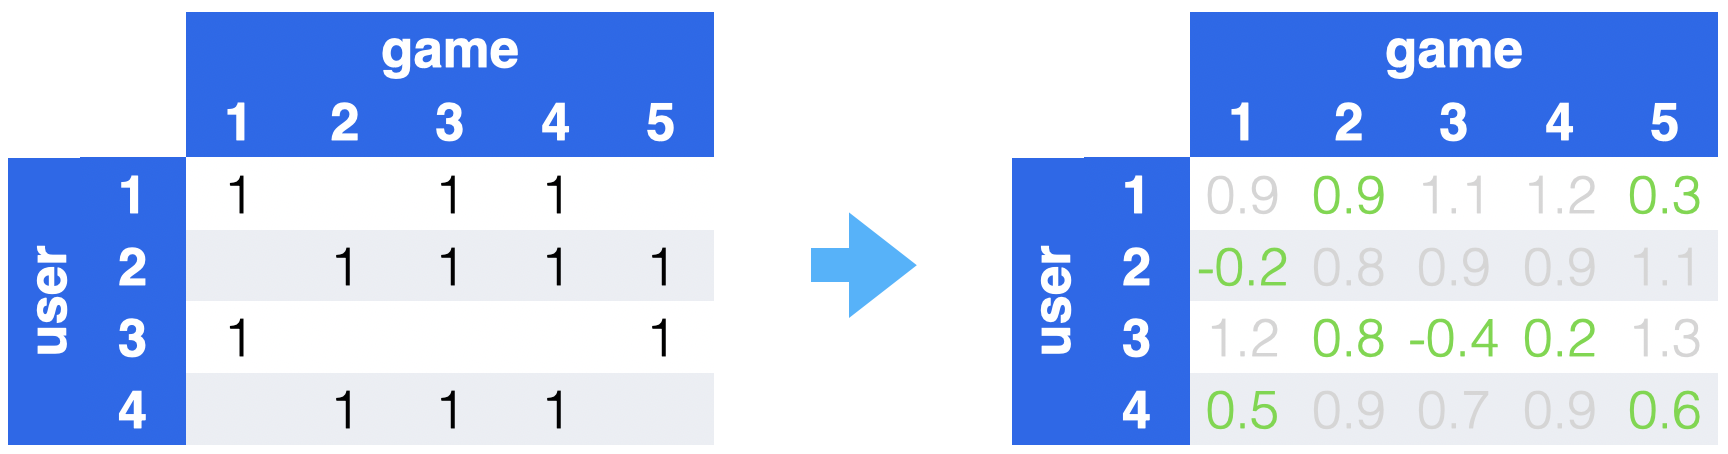

Now, let's stop talking and start to code.

First, we're going to load the values of our interaction matrix into the `x` variable.

In [6]:
x = users_items_matrix_df.values
print(x.shape)

(3757, 5113)


Now it's time to build the model. For this, we'll use Keras `Dense` layers. There are a few things we can highlight about this model:
- first, the input dimension is 5113 (games);
- in the encoder part, we have only one layer, where the input dimension is reduced to 512 dimensions
- our embeddings have 256 dimensions. Therefore, we are compressing the original 5k-dimensional space to only 256. This is about 5% of the original space. A lot of compression!
- in the decoder part, we get back to 512 dimensions and finally to the original 5113-dimension space (`users_items_matrix_df.shape[1]`).

And also a few comments about the training:
- we employ a linear activation function in the end, since we'll use the MSE as the loss function. We could also use sigmoid to avoid non-negative results. Feel free to change it.
- we use Adam as our optimizer
- we use Dropout after the embeddings layer. It helps to avoid overfitting.
- we train the model for 50 epochs. Feel free to test with other architectures and hyperparameters!

In [11]:
model = Sequential([
    Dense(units=512, activation='selu', name='enc_1', input_dim=users_items_matrix_df.shape[1]),
    Dense(units=256, activation='selu', name='embeddings'),
    Dropout(rate=0.8, name='dropout'),
    Dense(units=512, activation='selu', name='dec_1'),
    Dense(units=users_items_matrix_df.shape[1], activation='linear', name='user_score_pred')
])
model.summary()

/home/shegun93/anaconda3/envs/Qml/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_1 (Dense)                   │ (None, 512)            │     2,618,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1 (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_score_pred (Dense)         │ (None, 5113)           │     2,622,969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,504,249 (21.00 MB)

 Trainable params: 5,504,249 (21.00 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
hist = model.fit(x, x, epochs=50, batch_size=64, shuffle=True, validation_split=0.1)

Epoch 1/50


2025-07-10 13:11:36.049342: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69148212 exceeds 10% of free system memory.
2025-07-10 13:11:36.152042: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69148212 exceeds 10% of free system memory.


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0339 - val_loss: 0.0043
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0209 - val_loss: 0.0035
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0164 - val_loss: 0.0031
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0120 - val_loss: 0.0029
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0107 - val_loss: 0.0027
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0090 - val_loss: 0.0026
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.

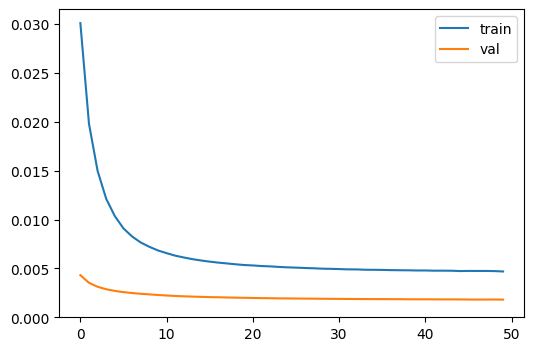

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.ylim(0)
plt.legend()

# Game Recommendation

Now that we've trained our model, it's time to make some recommendations.

First, we're going to load model predictions and filter only the values that were initially zero (i.e., there was no interaction between the user and game).

In [15]:
new_matrix = model.predict(x) * (x == 0)

 13/118 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-07-10 13:17:08.349233: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76838164 exceeds 10% of free system memory.


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


2025-07-10 13:17:09.696265: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76838164 exceeds 10% of free system memory.


In [16]:
new_users_items_matrix_df = pd.DataFrame(
    new_matrix,
    columns=users_items_matrix_df.columns,
    index=users_items_matrix_df.index
)
new_users_items_matrix_df.head()

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.003257,0.004685,0.005737,0.004677,0.000909,-0.000200,0.002206,-0.001455,0.001933,0.000545,...,0.004561,-0.004486,-0.009038,0.008876,-0.004188,-0.011327,0.003059,-0.000086,-0.037740,-0.005507
1,0.001257,0.005809,-0.000254,0.016924,0.002533,0.018264,0.000712,0.007234,0.004887,-0.003858,...,-0.009193,0.007516,0.004672,0.034809,0.000737,0.002810,0.010715,0.000725,0.048443,0.001610
2,0.008068,-0.004340,0.004360,0.015495,-0.022319,0.015505,0.019168,-0.000099,0.006913,-0.013350,...,-0.009433,-0.012370,0.005147,0.053035,-0.006008,0.022360,0.004087,0.018225,-0.017018,-0.019778
3,-0.001511,0.005509,0.001350,0.007262,0.002974,-0.003572,0.003941,0.006667,0.008921,0.002082,...,0.006461,-0.003520,0.002966,0.007848,-0.000738,0.003333,0.006066,0.004738,-0.001979,-0.001188
4,-0.006084,0.000313,0.001807,0.004797,0.007606,-0.005865,-0.002353,0.004465,0.004542,0.000201,...,0.004816,-0.007073,0.000787,0.013754,0.000229,-0.002286,0.004032,-0.001726,0.005976,-0.003160


As mentioned before, the values that were originally zero are now filled with some decimal number. Therefore, **the model tells us about the supposed interaction between the given user and the game**. The closer it is to 1, the more likely it is that the user likes that game.

With this matrix, in order to recommend a game to a user, all we need to do is sort the rows by these values and get the corresponding games:

In [17]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    pred_scores = interact_matrix.loc[user_id].values

    df_scores = pd.DataFrame({
        'content_id': list(users_items_matrix_df.columns), 
        'score': pred_scores
    })

    df_rec = (df_scores
        .set_index('content_id')
        .join(df_content.set_index('content_id'))
        .sort_values('score', ascending=False)
        .head(topn)[['score', 'game']]
    )

    return df_rec[df_rec.score > 0]

Now, let's make some recommendations!

First, let's see the games that a specific user has played before:

In [18]:
recommender_for_user(user_id=1011, interact_matrix=users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2058,1.0,Half-Life 2 Episode Two
2059,1.0,Half-Life 2 Lost Coast
2057,1.0,Half-Life 2 Episode One


Taking a look at these games, we can see that user (1011) likes FPS games. 

What are the games that the Autoencoder will recommend to this user? Let's see:

In [19]:
recommender_for_user(user_id=1011, interact_matrix=new_users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
2056,0.327751,Half-Life 2 Deathmatch
978,0.213149,Counter-Strike Source
3197,0.186451,Portal 2
2062,0.173522,Half-Life Deathmatch Source
2457,0.146772,Left 4 Dead 2
1126,0.117076,Day of Defeat Source
2064,0.113554,Half-Life Source
2456,0.102827,Left 4 Dead
4750,0.092756,Unturned


The autoencoder recommended other FPS games, especially other episodes of the games he played before (like Half-Life and Portal). 

Furthermore, there is something very important to highlight here. Did you remember that the original matrix only told us if a user had bought a game? Therefore, the Autoencoder has no features about the user (e.g., sex, age) or the game (e.g., genre, studio). If you take a look at the games the user played before and the recommended games, you will notice that they are from Valve. Thus, somehow the Autoencoder learned to encode it into the embeddings. How amazing is it? 🤩

> 💡 Autoencoders can learn features that are not originally in the dataset. This is the magic of embeddings!

Now, let's take a look at other user:

In [20]:
recommender_for_user(user_id=1319, interact_matrix=users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
2661,1.0,Medieval II Total War
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4330,1.0,The Elder Scrolls V Skyrim - Dragonborn
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4328,1.0,The Elder Scrolls V Skyrim
1301,1.0,Divinity Original Sin Enhanced Edition


We can see now that this user prefers RPGs and strategy games. Let's take a look at what our model will recommend to this user:

In [21]:
recommender_for_user(user_id=1319, interact_matrix=new_users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
3837,0.267733,Skyrim High Resolution Texture Pack
2872,0.197583,Napoleon Total War
3792,0.176791,Sid Meier's Civilization V
4632,0.140900,Total War SHOGUN 2 - Fall of the Samurai
1667,0.134094,Fallout New Vegas
3793,0.124198,Sid Meier's Civilization V Brave New World
2784,0.116668,Mount & Blade Warband
1668,0.112991,Fallout New Vegas Courier's Stash
3558,0.110552,Rome Total War


Awesome! The Autoencoder recommends other games similar to the ones the user is used to playing. What do you think about these recommendations? 

Finally, if you want to try it out on a random user, just run the cell below:

In [22]:
random_idx = np.random.choice(df.user_id.values, size=1)[0]
recommender_for_user(user_id=random_idx, interact_matrix=users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
2672,1.0,Memories of a Vagabond
3034,1.0,Overlord II
3529,1.0,Road Redemption
4675,1.0,Trine 2
4674,1.0,Trine
3525,1.0,Risk of Rain
2261,1.0,Interstellar Marines
3032,1.0,Overlord
3035,1.0,Overlord Raising Hell


In [23]:
recommender_for_user(user_id=random_idx, interact_matrix=new_users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
3792,1.006842,Sid Meier's Civilization V
2326,0.844878,Just Cause 2
921,0.805097,Company of Heroes
205,0.679120,Alan Wake
927,0.661908,Company of Heroes Opposing Fronts
1133,0.623737,Dead Island
4221,0.623594,Team Fortress 2
1108,0.615377,Darksiders
1033,0.615312,Crysis 2 Maximum Edition
